In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
import numpy as np
import heapq
from haversine import haversine, Unit
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

### Read in DFs & clean


In [3]:
nascar_tracks_clean = pd.read_pickle("../../21_6_7/notebooks/nascar_tracks_clean.pkl")

In [4]:
closest_10_stations_df = pd.read_pickle("../../21_6_7/notebooks/nearest_10_stations.pkl")

In [5]:
lead_data_df = pd.read_csv('../input_data/daily_lead_80_20.csv', encoding = 'latin1')

In [6]:
lead_data_df['date'] = pd.to_datetime(lead_data_df['date1'])

In [7]:
daily_lead_unique = pd.read_pickle("../../21_6_7/notebooks/daily_lead_unique.pkl")

In [8]:
daily_lead_unique['date'] = pd.to_datetime(lead_data_df['date1'])

In [9]:
daily_lead_unique['latitude'] = daily_lead_unique['latitude'].astype(float)
daily_lead_unique['longitude'] = daily_lead_unique['longitude'].astype(float)

### Descriptive stats of the distances between each track and its nearest 10 stations 

In [10]:
closest_10_stations_df['mean (mi)'] = [np.array(x).mean() for x in closest_10_stations_df['closest_dist (mi)'].values]

In [11]:
closest_10_stations_df['median (mi)'] = [pd.array(x).median() for x in closest_10_stations_df['closest_dist (mi)'].values]

In [12]:
closest_10_stations_df['std (mi)'] = [pd.array(x).std() for x in closest_10_stations_df['closest_dist (mi)'].values]

In [13]:
closest_10_stations_df['max_dist (mi)'] = [max(x) for x in closest_10_stations_df['closest_dist (mi)']]
closest_10_stations_df['min_dist (mi)'] = [min(x) for x in closest_10_stations_df['closest_dist (mi)']]
closest_10_stations_df[['track','mean (mi)', 'median (mi)', 'max_dist (mi)', 'min_dist (mi)', 'std (mi)']].head(10)

,track,mean (mi),median (mi),max_dist (mi),min_dist (mi),std (mi)
0,Fairgrounds Speedway Nashville - Nashville Sp...,3.82036,3.51795,5.7331,0.9625,1.615062
1,Riverside International Raceway,12.74350,11.97260,18.4266,7.4298,3.628201
2,North Wilkesboro Speedway,56.89182,59.08725,67.2047,33.3501,11.383779
3,Rockingham Speedway - North Carolina Motor Spe...,54.18357,55.92675,71.4890,38.7459,11.169350
4,Chicagoland Speedway,4.68642,4.28520,8.1608,2.1770,1.693405
5,"Sonoma Raceway - Infineon Raceway, Sears Point...",17.87176,16.58725,24.0666,12.4191,4.569500
6,Watkins Glen International,63.00957,64.01695,67.3565,47.6771,5.691296
7,Auto Club Speedway - California Speedway,7.33885,7.63310,12.7961,0.9178,4.729754
8,Bristol Motor Speedway - Bristol International...,7.47975,3.97535,16.8714,0.8748,7.360972
9,Charlotte Motor Speedway - Lowe's Motor Speedway,49.31003,57.14570,75.7194,9.5155,24.083246


###  How many unique stations are there, per N years, over the entire 40 year period?

In [14]:
n_years = 1
(lead_data_df.groupby(lead_data_df.year.sub(1980)//n_years)['monitorID'].nunique()
                                        .reset_index().rename(columns={'year': 'time_period'})).head(10)

,time_period,monitorID
0,0,920
1,1,946
2,2,775
3,3,816
4,4,759
5,5,841
6,6,830
7,7,775
8,8,668
9,9,485


### How many times does each station record, per N years, over the 40 year period?

In [15]:
n_years = 1
(lead_data_df.groupby(lead_data_df.year.sub(1980)//n_years)['monitorID'].value_counts().to_frame()
             .rename(columns={'monitorID': 'count'}).reset_index()
             .rename(columns={'year': 'time_period'})).head(10)

,time_period,monitorID,count
0,0,534,349
1,0,431,295
2,0,631,175
3,0,1341,119
4,0,124,117
5,0,305,95
6,0,1805,95
7,0,1139,92
8,0,641,91
9,0,1044,90


###  How many times does each station record, per day, over the 40 year period?

In [16]:
daily_records_df = (lead_data_df.groupby('date')['monitorID'].value_counts()
                                     .to_frame().rename(columns={'monitorID': 'count'})
                                     .reset_index())

In [17]:
daily_records_df.sort_values('count', ascending=False).reset_index(drop=True).head(10)

,date,monitorID,count
0,2009-08-29,2329,5
1,2009-01-01,2329,5
2,2009-04-07,2329,5
3,2009-06-30,2329,5
4,2009-03-26,2329,5
5,2009-02-18,2329,5
6,2009-06-06,2329,5
7,2009-05-25,2329,5
8,2009-05-13,2329,5
9,2009-12-27,2329,5


### For each track, find all monitoring stations within X (80) km

In [18]:
def get_stations_within_thresh(point, points, monitor_ids, distance_thresh=80.4672):
    # finds distance between each track and every monitoring station
    dist = []
    for p in points:
        x = round(haversine(point, p), 4)
        dist.append(x)
    
    idxs = [i for i,v in enumerate(dist) if v <= distance_thresh]
    
    n_smallest_points = [points[idx] for idx in idxs] # monitor coordinates
    n_smallest_ids = [monitor_ids[idx] for idx in idxs] # monitor IDs
    n_smallest_dist = [dist[idx] for idx in idxs]

    return n_smallest_points, n_smallest_ids, n_smallest_dist

In [19]:
#daily_lead_96_18 = daily_lead_unique[(daily_lead_unique['year'] >= 1996) & (daily_lead_unique['year'] <= 2018 )].reset_index(drop=True).copy()

In [20]:
monitor_points = list(daily_lead_unique['point'])
monitor_ids = list(daily_lead_unique["monitorID"])

In [21]:
distance_thresh =  80.4672
nascar_tracks_clean['points_ids_dist'] = [get_stations_within_thresh(x, monitor_points, monitor_ids, distance_thresh) 
                                          for x in nascar_tracks_clean['point']]

In [22]:
nascar_tracks_clean["points_within_80km"] = nascar_tracks_clean["points_ids_dist"].apply(lambda x: x[0])
nascar_tracks_clean["ids_within_80km"] = nascar_tracks_clean["points_ids_dist"].apply(lambda x: x[1])
nascar_tracks_clean["distances (km)"] = nascar_tracks_clean["points_ids_dist"].apply(lambda x: x[2])

In [23]:
stations_within_80km = nascar_tracks_clean.drop(['points_ids_dist'], axis=1).copy()

In [24]:
stations_within_80km['mean (km)'] = [np.array(x).mean() for x in stations_within_80km['distances (km)'].values]

In [25]:
stations_within_80km = stations_within_80km.dropna(axis=0, subset=['mean (km)'])

In [26]:
stations_within_80km['median (km)'] = [pd.array(x).median() for x in stations_within_80km['distances (km)'].values]

In [27]:
stations_within_80km['std (km)'] = [pd.array(x).std() for x in stations_within_80km['distances (km)'].values]

In [28]:
stations_within_80km['max_dist (km)'] = [max(x) for x in stations_within_80km['distances (km)']]
stations_within_80km['min_dist (km)'] = [min(x) for x in stations_within_80km['distances (km)']]

In [29]:
stations_within_80km['num_stations'] = [len(x) for x in stations_within_80km['points_within_80km']]

In [30]:
stations_within_80_km = stations_within_80km[['track', 'city', 'state','point', 'points_within_80km', 'ids_within_80km', 'distances (km)', 'mean (km)',
                       'median (km)','max_dist (km)', 'min_dist (km)', 'std (km)', 'num_stations']].copy()

In [31]:
stations_within_80_km.to_csv('stations_within_80km_df.csv')

### Create Monitor-Year Frame

In [32]:
df_list = []
def get_monitor_counts(monitorID):
    df = (lead_data_df[lead_data_df['monitorID']==monitorID].groupby(['year','statename', 'cityname'])['monitorID']
                                                .value_counts().to_frame()
                                                .rename(columns={'monitorID': 'readings'}).reset_index())
    df_list.append(df)

In [33]:
l = []
for i in range(27):
    for x in stations_within_80km['ids_within_80km'].iloc[i]:
        l.append(x)
        get_monitor_counts(x)

In [34]:
import collections
print([item for item, count in collections.Counter(l).items() if count > 1])

[2095, 203, 2123, 1838, 13, 2411, 2350, 2268, 205, 1891, 2412, 2330, 2437, 564, 2402, 2235, 2373, 1013, 354, 2154, 2372, 1926, 1839, 1062, 2185, 2315, 2449, 1615, 1617, 2301, 2300, 2098, 2088, 2089, 2092, 1152, 328, 522, 139, 138]


In [35]:
monitor_records = pd.concat(df_list).reset_index(drop=True)

In [36]:
monitor_records

,year,statename,cityname,monitorID,readings
0,1980,Kentucky,Russellville,255,3
1,1981,Kentucky,Russellville,255,9
2,1980,Kentucky,Franklin,89,3
3,1981,Kentucky,Franklin,89,8
4,1980,Tennessee,Not in a city,305,95
...,...,...,...,...,...
4686,2012,Alabama,Birmingham,1176,121
4687,2013,Alabama,Birmingham,1176,118
4688,2014,Alabama,Birmingham,1176,119
4689,2015,Alabama,Birmingham,1176,119


In [37]:
monitor_records.to_csv('monitors_within_50mi_yearly_readings.csv')

### Plot readings per year of monitors within 50 mi of tracks

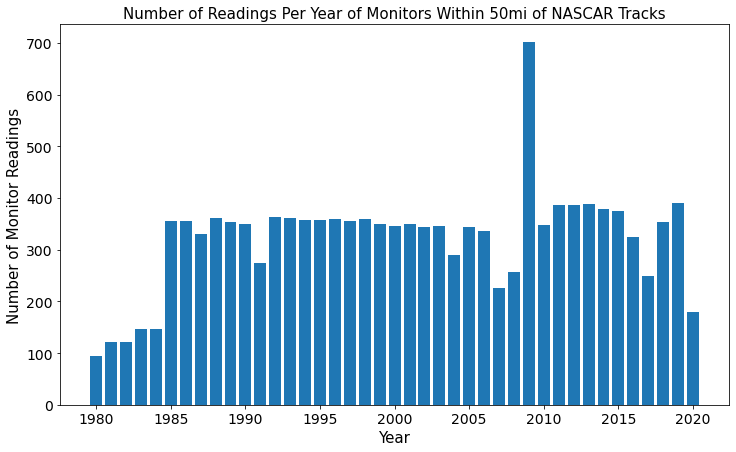

In [38]:
fig = plt.figure(figsize = (12, 7))
plt.xlabel("Year", size=15)
plt.ylabel("Number of Monitor Readings", size =15)
plt.title("Number of Readings Per Year of Monitors Within 50mi of NASCAR Tracks", size=15)
monitors = list(monitor_records['year'])
readings = list(monitor_records['readings'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.bar(monitors, readings)
plt.show()

### For each track, find N closest stations - long format

In [39]:
long = []
for index, row in closest_10_stations_df.iterrows():
    for i in range(1,11):
        lis =  row[["track", 'city', 'state', 'country', 'first race', 'last race', '# races', 'point',
                                      f"closest_point_{i}", f"closest_id_{i}", f"closest_dist_{i}", 
                                   'mean (mi)', 'median (mi)', 'max_dist (mi)', 'min_dist (mi)', 'std (mi)']].values.flatten().tolist()
        long.append(lis)

In [40]:
df_cols = ["track", 'city', 'state', 'country', 'first race', 'last race', '# races',
           'track_coordinate', 'closest_stations', 'closest_ids', 'closest_dist (mi)', 'mean (mi)', 'median (mi)', 'max_dist (mi)', 'min_dist (mi)','std (mi)']

In [41]:
closest_10_stations_long = pd.DataFrame(long, columns=df_cols)

In [42]:
closest_10_stations_long.head()

,track,city,state,country,first race,last race,# races,track_coordinate,closest_stations,closest_ids,closest_dist (mi),mean (mi),median (mi),max_dist (mi),min_dist (mi),std (mi)
0,Fairgrounds Speedway Nashville - Nashville Sp...,Nashville,TN,US,1958,1984,42,"(36.130769, -86.762146)","(36.143299, -86.75460799999999)",303,0.9625,3.82036,3.51795,5.7331,0.9625,1.615062
1,Fairgrounds Speedway Nashville - Nashville Sp...,Nashville,TN,US,1958,1984,42,"(36.130769, -86.762146)","(36.160278000000005, -86.791664)",1321,2.6210,3.82036,3.51795,5.7331,0.9625,1.615062
2,Fairgrounds Speedway Nashville - Nashville Sp...,Nashville,TN,US,1958,1984,42,"(36.130769, -86.762146)","(36.10006, -86.734444)",1229,2.6254,3.82036,3.51795,5.7331,0.9625,1.615062
3,Fairgrounds Speedway Nashville - Nashville Sp...,Nashville,TN,US,1958,1984,42,"(36.130769, -86.762146)","(36.152279, -86.807777)",853,2.9481,3.82036,3.51795,5.7331,0.9625,1.615062
4,Fairgrounds Speedway Nashville - Nashville Sp...,Nashville,TN,US,1958,1984,42,"(36.130769, -86.762146)","(36.17638, -86.738899)",1191,3.4079,3.82036,3.51795,5.7331,0.9625,1.615062


In [43]:
closest_10_stations_long.to_csv('closest_10_stations_long.csv')

### Compare the descriptive stats our closest monitoring stations to tracks to that of the Hollingsworth and Rudik papers

In [44]:
stations_within_50mi = pd.read_csv('stations_within_50_mi.csv')

In [45]:
nascar_tracks = pd.read_pickle("../../21_6_7/notebooks/nascar_tracks_clean.pkl")

In [46]:
stations_within_50_mi = nascar_tracks.merge(stations_within_50mi, how='inner', left_on=['track'], 
                                right_on=['track']).reset_index(drop=True)

In [47]:
stations_within_50mi_df = stations_within_50_mi.drop(['lat', 'long', 'Unnamed: 0', 'point_y', 'country'], axis=1)

In [48]:
stations_within_50mi_df = stations_within_50mi_df.rename(columns={'point_x': 'track_coord'}).copy()

In [49]:
rows = []

In [50]:
### Manually enter data from the PDF paper in order to compare

In [51]:
l1 = ["Alabama International Motor Speedway", "Talladega, AL", 2.66, 43.47, 1.62, 42.04, 45.23, 0.12, 0.26, 0, 1]
l2 = ["ISM Raceway", "Avondale, AZ", 1.00, 14.86, 1.38, 13.75, 16.33, 0.27, 0.25, 0, 0]
l3 = ["Tucson Raceway Park", "Tucson, AZ", 0.38, 16.35, 4.23, 12.69, 20.01, 0.15, 0.03, 0, 0]
l4 = ["Auto Club Speedway", "Fontana, CA", 2.00, 26.74, 15.96, 0.91, 47.09, 4.66, 6.23, 1, 0]
l5 = ["Infineon Raceway", "Sonoma, CA", 1.99, 25.06, 6.10, 15.00, 31.90, 0.46, 0.35, 1, 0]
l5 = ["Colorado National Speedway", "Erie, CO", 0.38, 20.08, 3.29, 16.33, 25.19, 0.54, 0.13, 0, 0]
l5 = ["Pikes Peak International Raceway", "Fountain, CO", 1.00, 21.29, 3.34, 18.28, 24.85, 0.93, 0.63, 0, 0]
l6 = ["Dover Downs International Speedway", "Dover, DE", 1.00, 37.14, 9.45, 14.11, 45.40, 2.04, 3.96, 0, 1]
l7 = ["Daytona International Speedway", "Daytona Beach, FL", 2.50, 44.35, 0.00, 44.35, 44.35, 0.12, 0.16, 0, 1]
l8 = ["Homestead-Miami Speedway", "Homestead, FL", 1.50, 21.78, 0, 21.78, 21.78, 0.04, 0.03, 0, 0]
l9 = ["Lanier National Speedway", "Braselton, GA", 0.40, 15.48, 7.64, 10.09, 20.88, 0.08, 0.02, 0, 0]
l10 = ["Atlanta International Raceway", "Hampton, GA", 1.50, 31.60, 6.64, 28.01, 42.36, 0.31, 0.64, 1, 1]
l11 = ["Chicago Motor Speedway", "Cicero, IL", 1.00, 13.11, 6.39, 4.41, 21.77, 1.31, 0.59, 0, 0]
l12 = ["Gateway International Raceway", "Madison, IL", 1.25, 22.87, 10.26, 3.00, 31.17, 18.62, 12.58, 0, 0]
l13 = ["Illinois State Fairgrounds", "Springfield, IL", 1.00, 33.07, 2.65, 31.74, 38.08, 0.73, 0.19, 1, 1]
l14 = ["Anderson Speedway", "Anderson, IN", 0.25, 23.10, 10.09, 15.32, 39.07, 0.69, 0.10, 0, 0]
l15 = ["Indianapolis Raceway Park", "Clermont, IN", 0.69, 10.04, 5.19, 4.86, 16.47, 0.50, 0.16, 0, 0]
l16 = ["Indiana State Fairgrounds", "Indianapolis, IN", 1.00, 44.26, 0.14, 44.04, 44.33, 0.15, 0.04, 0, 1]
l17 = ["Salem Speedway", "Salem, IN", 0.50, 34.78, 4.74, 29.87, 39.00, 0.50, 0.13, 1, 1]
l18 = ["Indianapolis Motor Speedway", "Speedway, IN", 2.50, 25.47, 22.05, 3.83, 49.87, 3.12, 5.17, 1, 0]
l19 = ["Winchester Speedway", "Winchester, IN", 0.50, 20.70, 0.16, 20.52, 20.84, 2.27, 0.50, 0, 0]
l20 = ["Heartland Park Topeka", "Topeka, KS", 1.80, 12.35, 4.77, 8.39, 20.28, 0.19, 0.07, 0, 0]
l21 = ["Michigan Speedway"," Brooklyn, MI", 2.00, 35.04, 0.00, 35.04, 35.04, 0.08, 0.04, 0, 1]
l22 = ["Michigan International Speedway", "Brooklyn, MI", 2.00, 35.04, 0.00, 35.04, 35.04, 0.42, 0.63, 0, 1]
l23 = ["Flat Rock Speedway", "Flat Rock, MI", 0.25, 17.38, 1.45, 15.62, 18.58, 0.31, 0.02, 0, 0]
l24 = ["Berlin Raceway", "Marne, MI", 0.44, 15.50, 6.16, 9.01, 22.10, 0.35, 0.06, 0, 0]
l25 = ["I-70 Speedway", "Odessa, MO", 0.50, 39.90, 1.93, 38.12, 43.67, 0.35, 0.09, 0, 1]
l26 = ["Charlotte Motor Speedway", "Concord, NC", 1.50, 32.89, 3.10, 32.19, 46.23, 1.54, 2.93, 1, 1]
l27 = ["Hickory Motor Speedway", "Hickory, NC", 0.36, 5.87, 0, 5.87, 5.87, 0.04, 0.01, 0, 0]
l28 = ["North Carolina Motor Speedway", "Rockingham, NC", 1.00, 40.88, 0.77, 38.93, 41.58, 0.39, 0.75, 0, 1]
l29 = ["Flemington Speedway", "Flemington, NJ", 0.62, 41.59, 6.72, 20.40, 49.58, 4.74, 1.33, 0, 1]
l30 = ["Toledo Speedway", "Toledo, OH", 0.50, 42.51, 3.19, 36.42, 45.46, 2.20, 0.52, 0, 1]
l31 = ["Cloverleaf Speedway", "Valley View, OH", 0.25, 32.39, 5.90, 21.57, 47.83, 6.44, 8.65, 1, 1]
l32 = ["Pocono Raceway", "Long Pond, PA", 2.50, 36.40, 9.61, 18.09, 43.56, 5.63, 11.17, 0, 1]
l33 = ["Nazareth Speedway", "Nazareth, PA", 1.00, 34.99, 8.85, 7.66, 47.91, 5.51, 3.24, 1, 1]
l34 = ["Darlington Raceway", "Darlington, SC", 1.25, 25.44, 13.40, 9.17, 40.32, 2.35, 3.95, 1, 0]
l35 = ["Myrtle Beach Speedway", "Myrtle Beach, SC", 0.54, 27.08, 11.61, 5.23, 33.99, 0.73, 0.29, 1, 0]
l36 = ["Bristol International Raceway", "Bristol, TN", 0.53, 1.19, 2.80, 0.88, 42.73, 8.56, 8.55, 0, 0]
l37 = ["Memphis Motorsports Park", "Memphis, TN", 0.75, 14.88, 0.48, 13.99, 15.15, 1.23, 0.56, 0, 0]
l38 = ["Nashville Speedway", "Nashville, TN", 0.50, 20.92, 7.07, 2.63, 32.92, 2.35, 1.08, 0, 0]
l39 = ["Nashville Superspeedway", "Nashville, TN", 1.33, 21.72, 0.35, 20.37, 22.04, 2.20, 2.15, 0, 0]
l40 = ["Texas Motor Speedway", "Fort Worth, TX", 1.50, 30.21, 2.89, 27.27, 42.19, 15.73, 20.55, 1, 1]
l41 = ["Martinsville Speedway", "Martinsville, VA", 0.50, 38.71, 0.00, 38.71, 38.71, 0.08, 0.07, 0, 1]
l42 = ["Richmond Fairgrounds", "Richmond, VA", 0.50, 4.54, 2.22, 2.68, 7.01, 0.54, 0.84, 0, 0]
l43 = ["Evergreen Speedway", "Monroe, WA", 0.65, 26.08, 0.00, 26.08, 26.08, 0.19, 0.06, 1, 0]
l44 = ["Milwaukee Mile", "West Allis, WI", 1.00, 12.73, 14.69, 4.85, 38.64, 0.19, 0.23, 0, 0]
l45 = ["West Virginia Motor Speedway", "Mineral Wells, WV", 0.62, 5.51, 0, 5.51, 5.51, 0.04, 0.01, 0, 0]

rows.append(l1)
rows.append(l2)
rows.append(l3)
rows.append(l4)
rows.append(l5)
rows.append(l6)
rows.append(l7)
rows.append(l8)
rows.append(l9)
rows.append(l10)
rows.append(l11)
rows.append(l12)
rows.append(l13)
rows.append(l14)
rows.append(l15)
rows.append(l16)
rows.append(l17)
rows.append(l18)
rows.append(l19)
rows.append(l20)
rows.append(l21)
rows.append(l22)
rows.append(l23)
rows.append(l24)
rows.append(l25)
rows.append(l26)
rows.append(l27)
rows.append(l28)
rows.append(l29)
rows.append(l30)
rows.append(l31)
rows.append(l32)
rows.append(l33)
rows.append(l34)
rows.append(l35)
rows.append(l36)
rows.append(l37)
rows.append(l38)
rows.append(l39)
rows.append(l40)
rows.append(l41)
rows.append(l42)
rows.append(l43)
rows.append(l44)
rows.append(l45)

In [52]:
cols = ["Track", "Location", "Lap Length (mi.)", "Mean Monitor Dist. (mi)", "S.D.", "Min.", "Max.", "% of treated obs",
"% of treated obs accounting for miles driven at track", "Mean dist between 25 and 35 mi", "Mean dist between 30 and 50 mi"]

In [53]:
hr_df = pd.DataFrame(rows, columns=cols)

In [54]:
hr_df['city'] = hr_df['Location'].apply(lambda x: x.split(', ')[0])
hr_df['state'] = hr_df['Location'].apply(lambda x: x.split(', ')[1])

In [55]:
hr_df_ = hr_df.to_pickle("../../21_6_7/notebooks/hr_df_.pkl")

In [56]:
hr_df_compare = (hr_df.merge(stations_within_50mi_df, how='inner', left_on=['city', 'state'], 
                                right_on=['city', 'state'], indicator=True)).copy()

In [57]:
hr_df_comp = hr_df_compare.rename(columns={'Mean Monitor Dist. (mi)': 'H&R Table A5 Mean Dist (mi)', 
                             'mean (mi)': 'Our Mean Dist (mi)',
                              'min_dist (mi)': 'Our Min. Dist (mi)',
                              'max_dist (mi)': 'Our Max. Dist (mi)',
                              'Min.': 'H&R Table A5 Min. Dist (mi)',
                              'Max.': 'H&R Table A5 Max. Dist (mi)' }).copy()

In [58]:
hr_df_compare['mean_diff'] = hr_df_compare['Mean Monitor Dist. (mi)'] - hr_df_compare['mean (mi)']

In [59]:
hr_compare_mean = hr_df_compare.sort_values('mean_diff').copy()

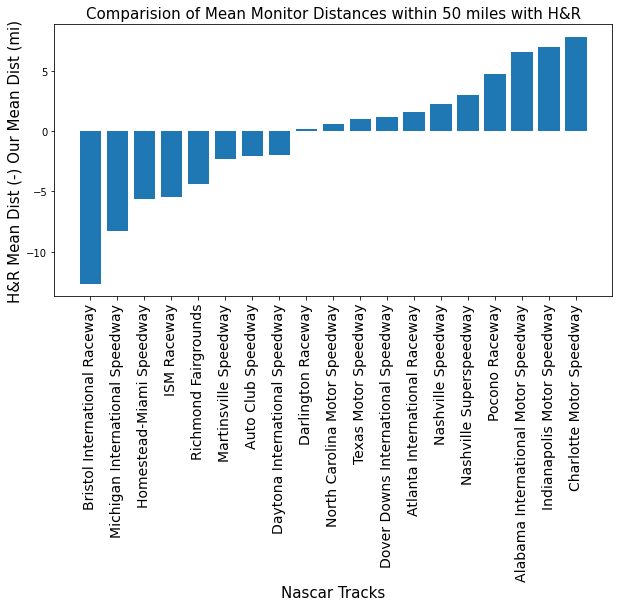

In [60]:
fig = plt.figure(figsize = (10, 5))
plt.xlabel("Nascar Tracks", size=15)
plt.ylabel("H&R Mean Dist (-) Our Mean Dist (mi)", size =15)
plt.title("Comparision of Mean Monitor Distances within 50 miles with H&R", size=15)
tracks = list(hr_compare_mean['Track'])
mean_diff = list(hr_compare_mean['mean_diff'])
plt.xticks(rotation=90)
plt.xticks(fontsize=14)
plt.bar(tracks, mean_diff)
plt.show()

<AxesSubplot:title={'center':'Comparision of Mean Monitor Distances Within 50 Miles of Each Track with H&R'}, xlabel='Nascar Tracks', ylabel='Mean Distance of Monitors Within 50 Miles'>

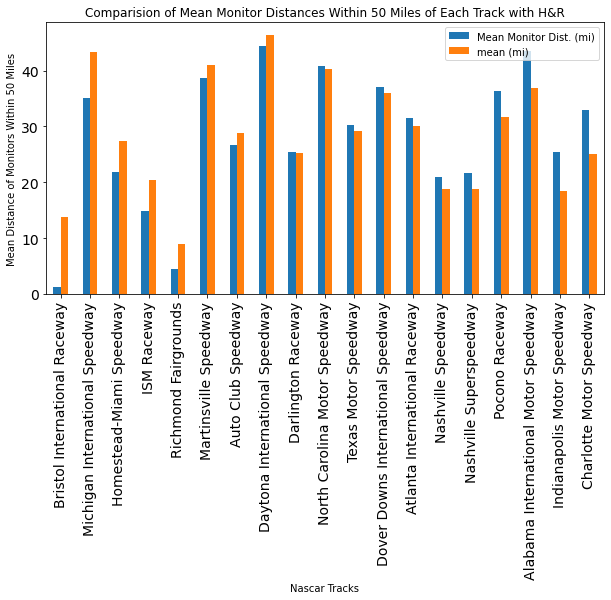

In [61]:
hr_compare_mean.plot(x="Track", y=["Mean Monitor Dist. (mi)", "mean (mi)"], kind="bar", xlabel='Nascar Tracks',
                  ylabel='Mean Distance of Monitors Within 50 Miles', figsize=(10,5), fontsize=14,
                  title='Comparision of Mean Monitor Distances Within 50 Miles of Each Track with H&R')

In [62]:
hr_df_comp['min_diff'] = hr_df_comp['H&R Table A5 Min. Dist (mi)'] - hr_df_comp['Our Min. Dist (mi)']

In [63]:
hr_compare_min = hr_df_comp.sort_values('min_diff').copy()

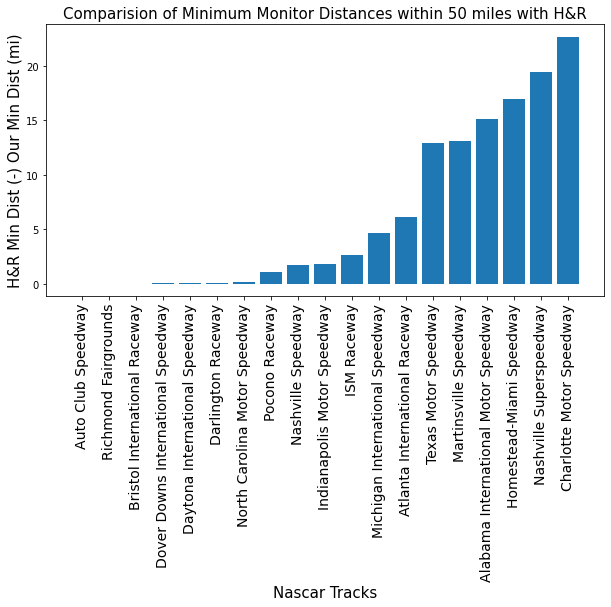

In [64]:
fig = plt.figure(figsize = (10, 5))
plt.xlabel("Nascar Tracks", size=15)
plt.ylabel("H&R Min Dist (-) Our Min Dist (mi)", size =15)
plt.title("Comparision of Minimum Monitor Distances within 50 miles with H&R", size=15)
tracks = list(hr_compare_min['Track'])
min_diff = list(hr_compare_min['min_diff'])
plt.xticks(rotation=90)
plt.xticks(fontsize=14)
plt.bar(tracks, min_diff)
plt.show()

<AxesSubplot:title={'center':'Comparision of Miumum Monitor Distances Within 50 Miles of Each Track with H&R'}, xlabel='Nascar Tracks', ylabel='Minimum Distance of Monitors Within 50 Miles'>

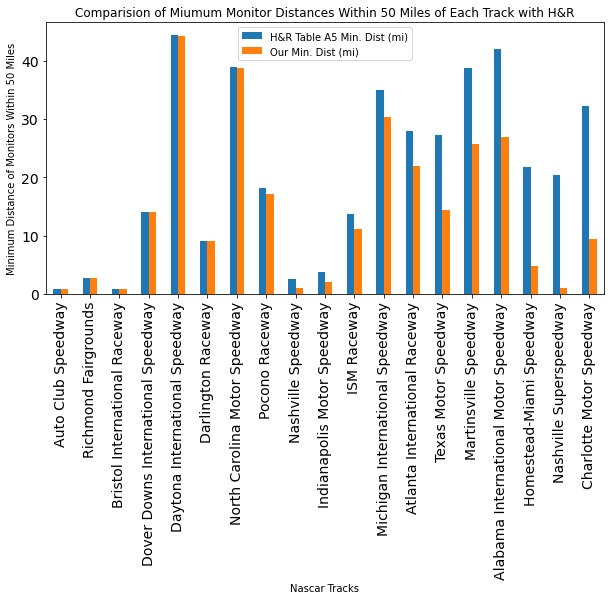

In [65]:
hr_compare_min.plot(x="Track", y=["H&R Table A5 Min. Dist (mi)", "Our Min. Dist (mi)"], kind="bar", 
                  xlabel='Nascar Tracks',
                  ylabel='Minimum Distance of Monitors Within 50 Miles', figsize=(10,5), fontsize=14,
                  title='Comparision of Miumum Monitor Distances Within 50 Miles of Each Track with H&R')

In [66]:
hr_df_comp['max_diff'] = hr_df_comp['H&R Table A5 Max. Dist (mi)'] - hr_df_comp['Our Max. Dist (mi)']

In [67]:
hr_compare_max = hr_df_comp.sort_values('max_diff').copy()

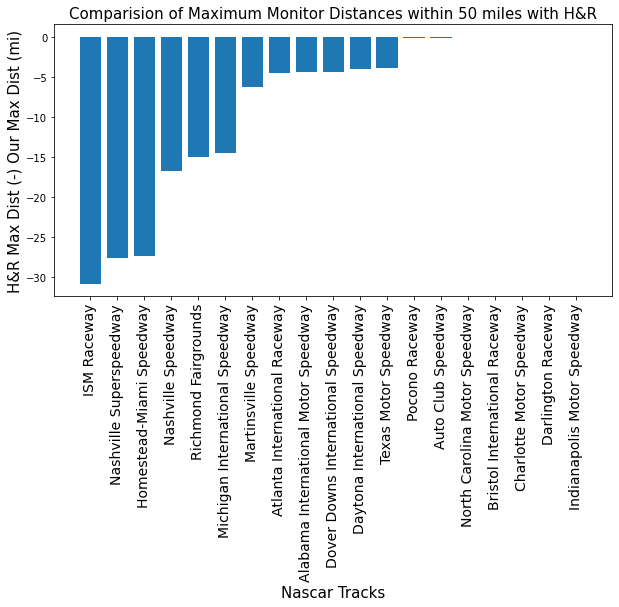

In [68]:
fig = plt.figure(figsize = (10, 5))
plt.xlabel("Nascar Tracks", size=15)
plt.ylabel("H&R Max Dist (-) Our Max Dist (mi)", size =15)
plt.title("Comparision of Maximum Monitor Distances within 50 miles with H&R", size=15)
tracks = list(hr_compare_max['Track'])
max_diff = list(hr_compare_max['max_diff'])
plt.xticks(rotation=90)
plt.xticks(fontsize=14)
plt.bar(tracks, max_diff)
plt.show()

<AxesSubplot:title={'center':'Comparision of Maximum Monitor Distances Within 50 Miles of Each Track with H&R'}, xlabel='Nascar Tracks', ylabel='Maximum Distance of Monitors Within 50 Miles'>

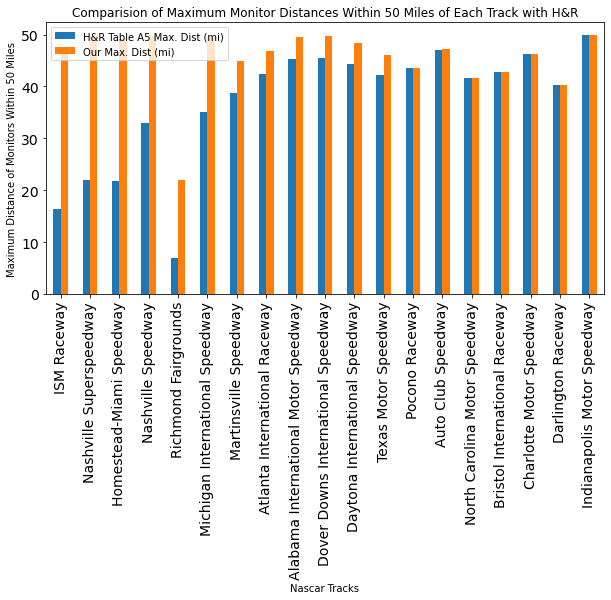

In [69]:
hr_compare_max.plot(x="Track", y=["H&R Table A5 Max. Dist (mi)", "Our Max. Dist (mi)"], kind="bar", 
                  xlabel='Nascar Tracks',
                  ylabel='Maximum Distance of Monitors Within 50 Miles', figsize=(10,5), fontsize=14,
                  title='Comparision of Maximum Monitor Distances Within 50 Miles of Each Track with H&R')